In [1]:
import os, glob, h5py, cv2

import pandas as pd
import numpy as np
# import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
# import imgaug as aug
# import imgaug.augmenters as iaug
import keras.callbacks as kcall #######
import tensorflow as tf

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Activation, Dense, Conv2D, SeparableConv2D, MaxPooling2D, \
    Input, Dropout, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras import backend as K

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
trainDir = '/floyd/input/vbData/train/'
validationDir = '/floyd/input/vbData/val/'
testDir = '/floyd/input/vbData/test/'

In [3]:
imgShape = 299
seedVal = 5555
batchSize = 256

trainDatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 5,
    width_shift_range = 0.1,
    height_shift_range = 0.05,
    shear_range = 0.1,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = "reflect")

valDatagen = ImageDataGenerator(rescale=1./255)
testDatagen = ImageDataGenerator(rescale=1./255)

# training_batch_size = 32
# validation_batch_size = 32

trainGenerator = trainDatagen.flow_from_directory(
    trainDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShape, imgShape),            # Resizes all images
    batch_size = batchSize,
    class_mode = 'categorical',
    shuffle = True,
    seed = seedVal)

validationGenerator = valDatagen.flow_from_directory(
    validationDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShape, imgShape),
    batch_size= 16,
    class_mode = 'categorical',
    shuffle = True,
    seed = seedVal)

testGenerator = testDatagen.flow_from_directory(
    testDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShape, imgShape),
    batch_size= 1,
    class_mode = 'categorical',
    shuffle = False)

Found 3851 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [4]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(imgShape,imgShape,3))
# base_model.summary()

87916544/87910968 [==============================] - 5s 0us/step


In [5]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(trainable = True),
    Dense(2048, activation= 'relu', trainable = True),
    Dropout(rate = 0.3, trainable = True),
    Dense(2, activation = 'softmax', trainable = True),
])

for layer in base_model.layers:
    layer.trainable = False
    
from keras import optimizers
model.compile(loss = "categorical_crossentropy", 
                    optimizer = Adam(lr= 0.001), 
                    metrics=["accuracy"])

In [6]:
import glob, math

t = []
for filename in glob.iglob('/floyd/input/vbData/train/**/*jpeg', recursive=True):
    t.append(filename)
print(len(t))
trainStepSize = math.ceil(len(t)/batchSize)
    
v = []
for filename in glob.iglob('/floyd/input/vbData/val/**/*jpeg', recursive=True):
    v.append(filename)
print(len(v))
valStepSize = math.ceil(len(v)/batchSize)

nl = []
for filename in glob.iglob('/floyd/input/vbData/train/VIRAL/*jpeg', recursive=True):
    nl.append(filename)
    
pneumo = []
for filename in glob.iglob('/floyd/input/vbData/train/BACTERIAL/*jpeg', recursive=True):
    pneumo.append(filename)
    
weightAdjust = len(nl)/len(pneumo)
weightAdjust

3851
32


0.5269627279936558

In [7]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vbModelCheck_InceptionV3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [8]:
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [9]:
model.fit_generator(
    trainGenerator,
    steps_per_epoch = trainStepSize,
    epochs = 12,
    class_weight = {0: 1.,1: weightAdjust},
    validation_data = validationGenerator,
    validation_steps = valStepSize,
    use_multiprocessing = True,
    callbacks = [checkpoint, early, tensorboard])

Epoch 1/12
16/16 [==============================] - 153s 10s/step - loss: 1.1339 - acc: 0.5510 - val_loss: 0.6391 - val_acc: 0.6875

Epoch 00001: val_acc improved from -inf to 0.68750, saving model to vbModelCheck_InceptionV3.h5
Epoch 2/12
16/16 [==============================] - 135s 8s/step - loss: 0.4549 - acc: 0.5515 - val_loss: 0.6886 - val_acc: 0.5625

Epoch 00002: val_acc did not improve from 0.68750
Epoch 3/12
16/16 [==============================] - 138s 9s/step - loss: 0.4498 - acc: 0.6206 - val_loss: 0.7076 - val_acc: 0.5625

Epoch 00003: val_acc did not improve from 0.68750
Epoch 4/12
16/16 [==============================] - 138s 9s/step - loss: 0.4234 - acc: 0.6913 - val_loss: 0.6460 - val_acc: 0.6875

Epoch 00004: val_acc did not improve from 0.68750
Epoch 5/12
16/16 [==============================] - 140s 9s/step - loss: 0.4097 - acc: 0.6979 - val_loss: 0.6398 - val_acc: 0.6875

Epoch 00005: val_acc did not improve from 0.68750
Epoch 6/12
16/16 [=========================

In [15]:
model.save('vbModel_InceptionV3.h5')

In [16]:
# new_model = load_model("modelCheck_2.h5")

In [17]:
# evaluate the model
scores = model.evaluate_generator(testGenerator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 85.13%


In [18]:
probs = model.predict_generator(testGenerator)

pneumoProb = []
predClass = []
for ii in probs:
    pneumoProb.append(np.float32(ii[[1]]))
    predClass.append(ii[1]>0.5)
# np.asarray(pneumoProb)
# np.asarray(predClass)

y_true = testGenerator.classes
y_pred = np.multiply(predClass,1)
y_prob = np.asarray(pneumoProb)

             precision    recall  f1-score   support

          0       0.80      0.81      0.81       148
          1       0.88      0.88      0.88       242

avg / total       0.85      0.85      0.85       390



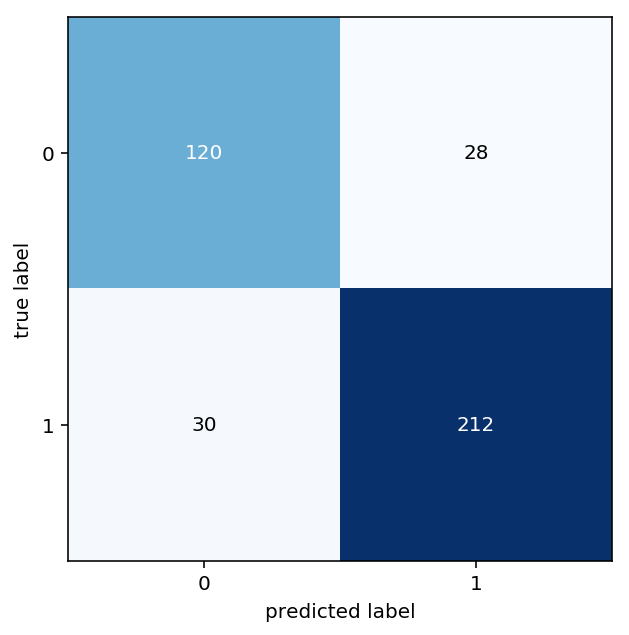

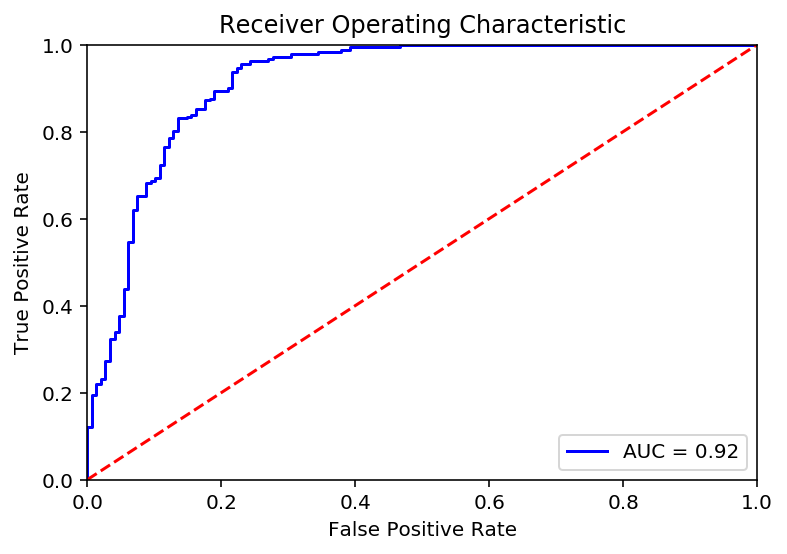

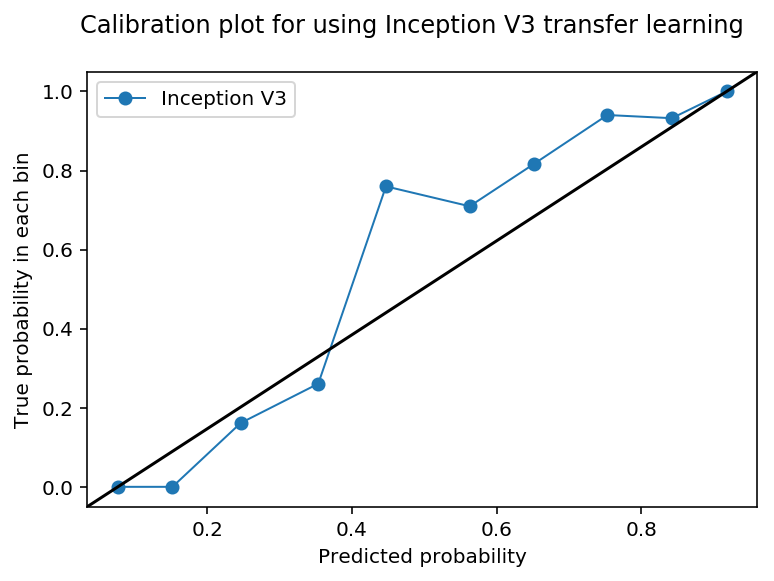

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

print(classification_report(y_true, y_pred))
CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

fpr, tpr, threshold = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

calib_y, calib_x = calibration_curve(y_true, y_prob, n_bins = 10)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(calib_x,calib_y, marker='o', linewidth=1, label='Inception V3')
# plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for using Inception V3 transfer learning')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

# Transfer learning using InceptionResNetV2

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model_InceptionResNetV2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(imgShape,imgShape,3))
# base_model.summary()

219062272/219055592 [==============================] - 13s 0us/step


In [21]:
model_InceptionResNetV2 = Sequential([
            base_model_InceptionResNetV2,
            GlobalAveragePooling2D(trainable = True),
            Dense(2048, activation= 'relu', trainable = True),
            Dropout(rate = 0.3, trainable = True),
            Dense(2, activation = 'softmax', trainable = True),
])

for layer in base_model_InceptionResNetV2.layers:
    layer.trainable = False
    
from keras import optimizers
model_InceptionResNetV2.compile(loss = "categorical_crossentropy", 
                                optimizer = Adam(lr= 0.001), 
                                metrics=["accuracy"])

In [22]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vbModelCheck_InceptionResNetV2.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [23]:
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [24]:
model_InceptionResNetV2.fit_generator(
            trainGenerator,
            steps_per_epoch = trainStepSize,
            epochs = 12,
            class_weight = {0: 1.,1: weightAdjust},
            validation_data = validationGenerator,
            validation_steps = valStepSize,
            use_multiprocessing = True,
            callbacks = [checkpoint, early, tensorboard])

Epoch 1/12
16/16 [==============================] - 156s 10s/step - loss: 0.8876 - acc: 0.5306 - val_loss: 0.6538 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to vbModelCheck_InceptionResNetV2.h5
Epoch 2/12
16/16 [==============================] - 134s 8s/step - loss: 0.4751 - acc: 0.5591 - val_loss: 0.6879 - val_acc: 0.6250

Epoch 00002: val_acc did not improve from 0.62500
Epoch 3/12
16/16 [==============================] - 146s 9s/step - loss: 0.4480 - acc: 0.6367 - val_loss: 0.6873 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.62500
Epoch 4/12
16/16 [==============================] - 144s 9s/step - loss: 0.4323 - acc: 0.6822 - val_loss: 0.6860 - val_acc: 0.5625

Epoch 00004: val_acc did not improve from 0.62500
Epoch 5/12
16/16 [==============================] - 150s 9s/step - loss: 0.4489 - acc: 0.6061 - val_loss: 0.7165 - val_acc: 0.5625

Epoch 00005: val_acc did not improve from 0.62500
Epoch 6/12
16/16 [===================

In [25]:
model_InceptionResNetV2.save('vbInceptionResNetV2epoch12.h5')

In [26]:
# evaluate the model
scores = model_InceptionResNetV2.evaluate_generator(testGenerator)
print("\n%s: %.2f%%" % (model_InceptionResNetV2.metrics_names[1], scores[1]*100))


acc: 89.49%


In [27]:
probsIRV2 = model_InceptionResNetV2.predict_generator(testGenerator)

pneumoProbIRV2 = []
predClassIRV2 = []
for ii in probsIRV2:
    pneumoProbIRV2.append(np.float32(ii[[1]]))
    predClassIRV2.append(ii[1]>0.5)
# np.asarray(pneumoProb)
# np.asarray(predClass)

y_true = testGenerator.classes
y_predIRV2 = np.multiply(predClassIRV2,1)
y_probIRV2 = np.asarray(pneumoProbIRV2)

             precision    recall  f1-score   support

          0       0.90      0.81      0.85       148
          1       0.89      0.95      0.92       242

avg / total       0.90      0.89      0.89       390



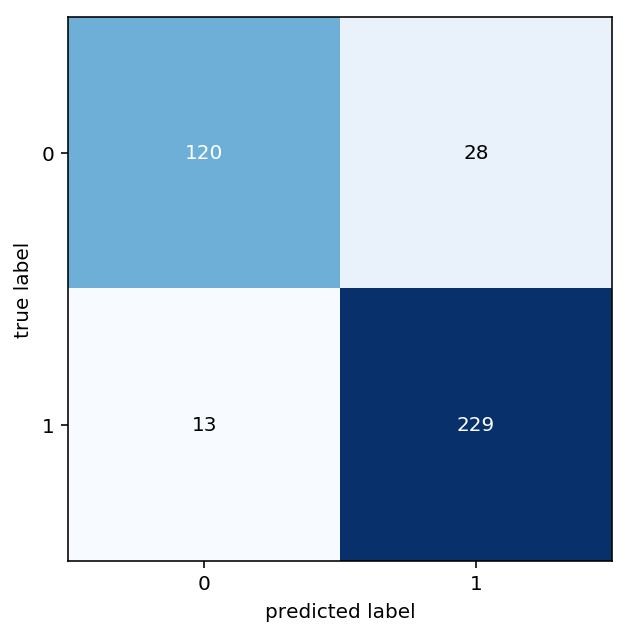

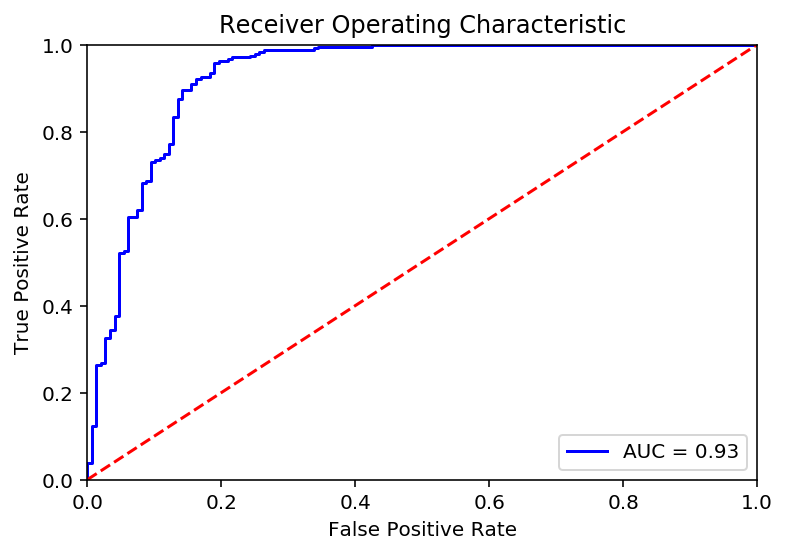

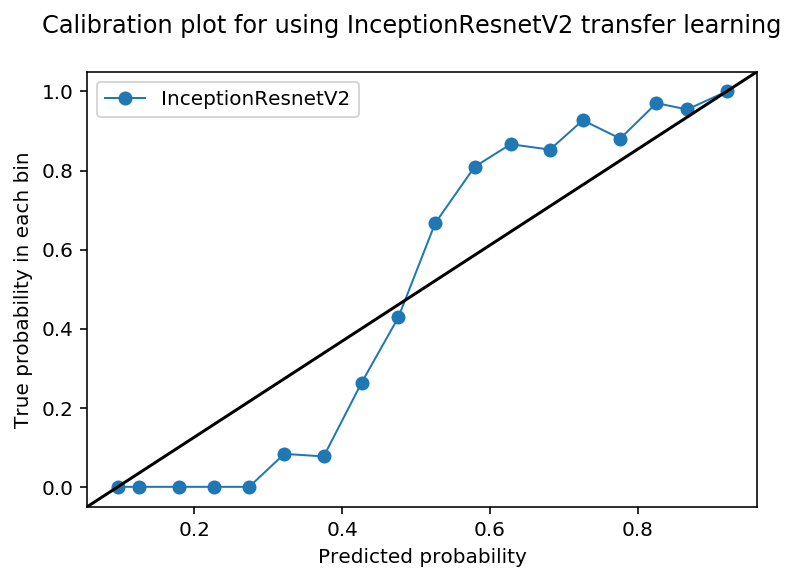

In [28]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

print(classification_report(y_true, y_predIRV2))
cmIRV2 = confusion_matrix(y_true, y_predIRV2)
fig, ax = plot_confusion_matrix(conf_mat=cmIRV2 ,  figsize=(5, 5))
plt.show()

fprIRV2, tprIRV2, threshold = roc_curve(y_true, y_probIRV2)
roc_aucIRV2 = auc(fprIRV2, tprIRV2)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprIRV2, tprIRV2, 'b', label = 'AUC = %0.2f' % roc_aucIRV2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

calib_yIRV2, calib_xIRV2 = calibration_curve(y_true, y_probIRV2, n_bins = 20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(calib_xIRV2,calib_yIRV2, marker='o', linewidth=1, label='InceptionResnetV2')
# plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for using InceptionResnetV2 transfer learning')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

# Transfer learning using MobileNet

In [29]:
imgShapeMN = 224
seedVal = 5555
batchSize = 256

trainDatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 5,
    width_shift_range = 0.1,
    height_shift_range = 0.05,
    shear_range = 0.1,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = "reflect")

valDatagen = ImageDataGenerator(rescale=1./255)
testDatagen = ImageDataGenerator(rescale=1./255)

# training_batch_size = 32
# validation_batch_size = 32

trainGeneratorMN = trainDatagen.flow_from_directory(
    trainDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShapeMN, imgShapeMN),            # Resizes all images
    batch_size = batchSize,
    class_mode = 'categorical',
    shuffle = True,
    seed = seedVal)

validationGeneratorMN = valDatagen.flow_from_directory(
    validationDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShapeMN, imgShapeMN),
    batch_size= 16,
    class_mode = 'categorical',
    shuffle = True,
    seed = seedVal)

testGeneratorMN = testDatagen.flow_from_directory(
    testDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShapeMN, imgShapeMN),
    batch_size= 1,
    class_mode = 'categorical',
    shuffle = False)

Found 3851 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [30]:
from keras.applications.mobilenet import MobileNet
# input_tensor = Input(shape=(imgShape, imgShape, 3))
base_model_MobileNet = MobileNet(include_top=False, weights='imagenet', input_shape = (224,224,3))
# base_model.summary()

17227776/17225924 [==============================] - 1s 0us/step


In [31]:
model_MobileNet = Sequential([
            base_model_MobileNet,
            GlobalAveragePooling2D(trainable = True),
            Dense(2048, activation= 'relu', trainable = True),
            Dropout(rate = 0.3, trainable = True),
            Dense(2, activation = 'softmax', trainable = True),
])

for layer in base_model_MobileNet.layers:
    layer.trainable = False
    
from keras import optimizers
model_MobileNet.compile(loss = "categorical_crossentropy", 
                        optimizer = Adam(lr= 0.001), 
                        metrics=["accuracy"])

In [35]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vbModelCheck_MobileNet.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [36]:
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [37]:
model_MobileNet.fit_generator(
            trainGeneratorMN,
            steps_per_epoch = trainStepSize,
            epochs = 12,
            class_weight = {0: 1.,1: weightAdjust},
            validation_data = validationGeneratorMN,
            validation_steps = valStepSize,
            use_multiprocessing = True,
            callbacks = [checkpoint, early, tensorboard])

Epoch 1/12
16/16 [==============================] - 102s 6s/step - loss: 0.8346 - acc: 0.6125 - val_loss: 0.7827 - val_acc: 0.7500

Epoch 00001: val_acc improved from -inf to 0.75000, saving model to vbModelCheck_MobileNet.h5
Epoch 2/12
16/16 [==============================] - 92s 6s/step - loss: 0.4009 - acc: 0.6967 - val_loss: 0.6841 - val_acc: 0.7500

Epoch 00002: val_acc did not improve from 0.75000
Epoch 3/12
16/16 [==============================] - 99s 6s/step - loss: 0.3909 - acc: 0.7200 - val_loss: 0.6675 - val_acc: 0.6875

Epoch 00003: val_acc did not improve from 0.75000
Epoch 4/12
16/16 [==============================] - 98s 6s/step - loss: 0.3859 - acc: 0.7259 - val_loss: 0.6882 - val_acc: 0.7500

Epoch 00004: val_acc did not improve from 0.75000
Epoch 5/12
16/16 [==============================] - 99s 6s/step - loss: 0.3716 - acc: 0.7455 - val_loss: 0.6745 - val_acc: 0.6875

Epoch 00005: val_acc did not improve from 0.75000
Epoch 6/12
16/16 [==============================] 

In [38]:
model_MobileNet.save('vbMobileNetEpoch12.h5')

In [39]:
# evaluate the model
scores = model_MobileNet.evaluate_generator(testGeneratorMN)
print("\n%s: %.2f%%" % (model_MobileNet.metrics_names[1], scores[1]*100))


acc: 92.05%


In [40]:
probsMN = model_MobileNet.predict_generator(testGeneratorMN)

pneumoProbMN = []
predClassMN = []
for ii in probsMN:
    pneumoProbMN.append(np.float32(ii[[1]]))
    predClassMN.append(ii[1]>0.5)
# np.asarray(pneumoProb)
# np.asarray(predClass)

y_true = testGeneratorMN.classes
y_predMN = np.multiply(predClassMN,1)
y_probMN = np.asarray(pneumoProbMN)

In [41]:
testGeneratorMN.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

             precision    recall  f1-score   support

          0       0.99      0.80      0.88       148
          1       0.89      1.00      0.94       242

avg / total       0.93      0.92      0.92       390



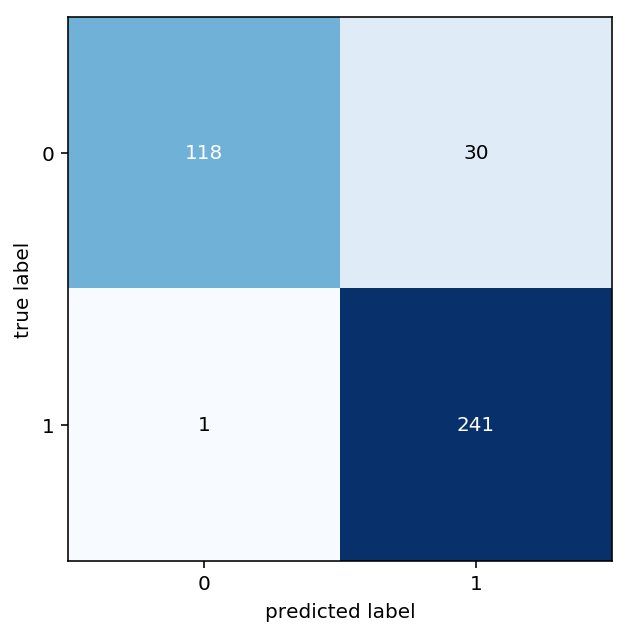

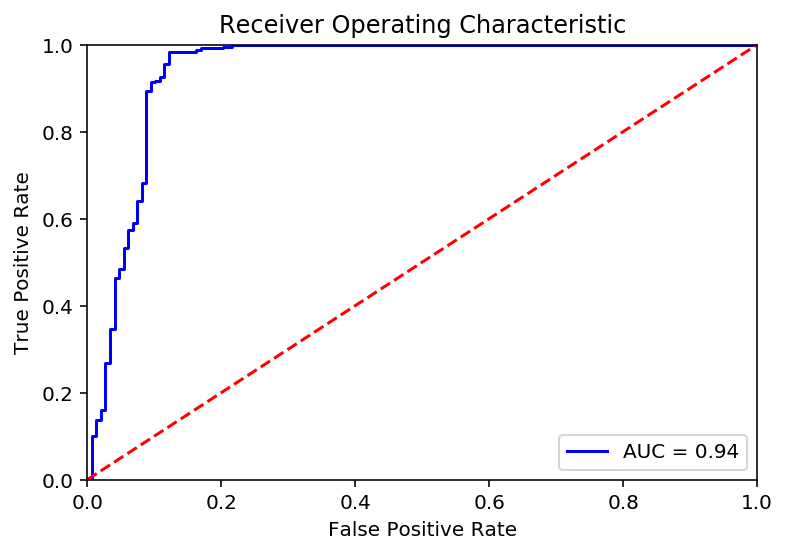

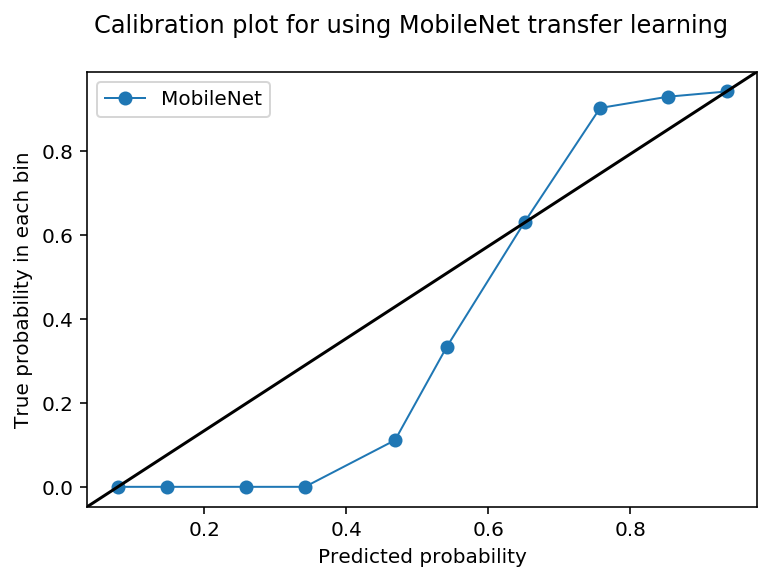

In [42]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

print(classification_report(y_true, y_predMN))
cmMN = confusion_matrix(y_true, y_predMN)
fig, ax = plot_confusion_matrix(conf_mat=cmMN ,  figsize=(5, 5))
plt.show()

fprMN, tprMN, threshold = roc_curve(y_true, y_probMN)
roc_aucMN = auc(fprMN, tprMN)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprMN, tprMN, 'b', label = 'AUC = %0.2f' % roc_aucMN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

calib_yMN, calib_xMN = calibration_curve(y_true, y_probMN, n_bins = 10)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(calib_xMN,calib_yMN, marker='o', linewidth=1, label='MobileNet')
# plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for using MobileNet transfer learning')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

# Creating Saliency Maps

In [43]:
from vis.utils import utils
from keras import activations 
from matplotlib import pyplot as plt

## Saliency on Inception V3

In [44]:
# inceptionTF = load_model("model_InceptionV3.h5")
vbInceptionTF = model

In [45]:
vbInceptionTF.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 26,003,234
Trainable params: 4,200,450
Non-trainable params: 21,802,784
_________________________________________________________________


In [46]:
vblayer_idx = utils.find_layer_idx(vbInceptionTF, "dense_2")

In [47]:
# Swap softmax with linear
vbInceptionTF.layers[vblayer_idx].activation = activations.linear
vbInceptionTF = utils.apply_modifications(vbInceptionTF)

In [66]:
testGeneratorAll = testDatagen.flow_from_directory(
    testDir,
    classes = ('VIRAL', 'BACTERIAL'),
    target_size = (imgShape, imgShape),
    batch_size= 390,
    class_mode = 'categorical',
    shuffle = False)

Found 390 images belonging to 2 classes.


[[0. 1.]]
(1, 299, 299, 3)
(1, 2)
(299, 299, 3)
[[0. 1.]]


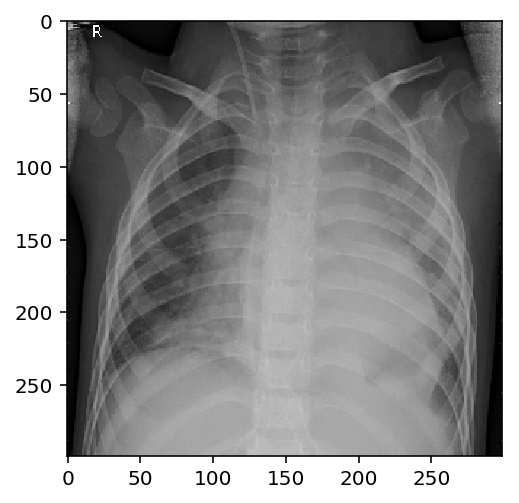

In [73]:
stopVal = 150
for ii in range(0,stopVal):
    x, y = next(testGenerator)

print(y)
print(x.shape)
print(y.shape)
tmp = x[0,:,:,:]
print(tmp.shape)
plt.imshow(tmp)

In [74]:
# x, y = next(testGenerator)
# print(x.shape)
# tmp = x[0,:,:,:]
# print(tmp.shape)
# print(y)
# plt.imshow(tmp)

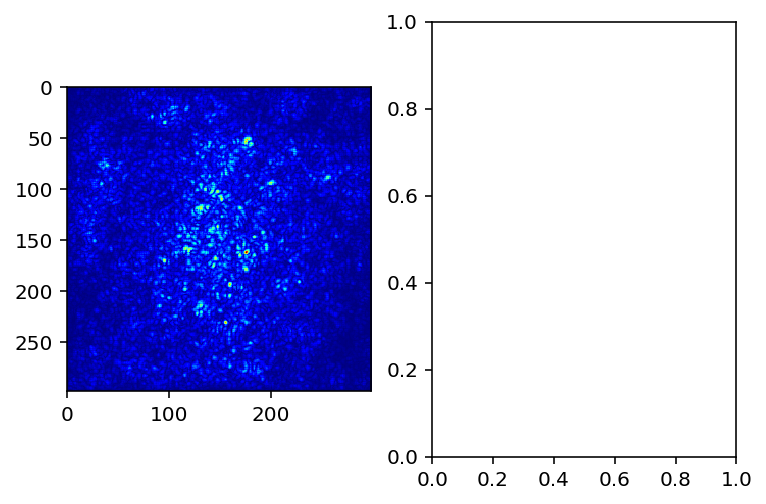

In [75]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

f, ax = plt.subplots(1, 2)
for i, img in enumerate([x]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(vbInceptionTF, vblayer_idx, filter_indices=None, seed_input=img, backprop_modifier=None)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

## Saliency on InceptionResNet

In [53]:
# vbInceptionResNetTF = load_model("inceptionResNetV2epoch12.h5")
vbInceptionResNetTF = model_InceptionResNetV2

In [54]:
vbInceptionResNetTF.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 57,488,610
Trainable params: 3,151,874
Non-trainable params: 54,336,736
_________________________________________________________________


In [55]:
vblayer_idxResNetTF = utils.find_layer_idx(vbInceptionResNetTF, "dense_4")

In [56]:
# Swap softmax with linear
vbInceptionResNetTF.layers[vblayer_idxResNetTF].activation = activations.linear
vbInceptionResNetTF = utils.apply_modifications(vbInceptionResNetTF)

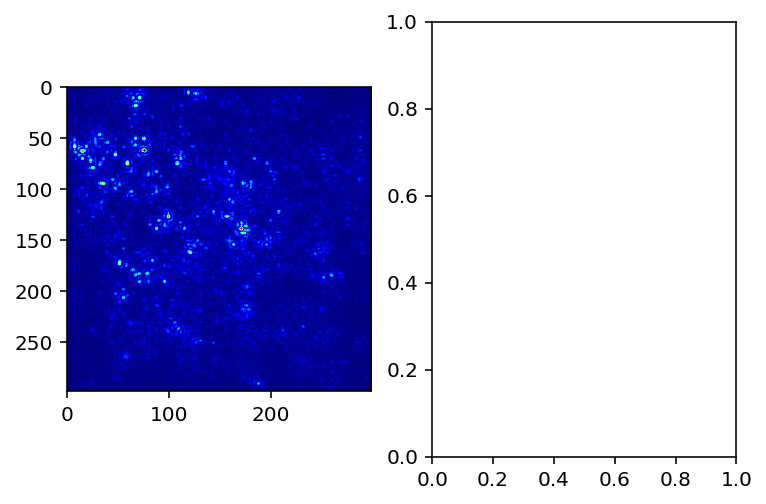

In [76]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

f, ax = plt.subplots(1, 2)
for i, img in enumerate([x]):    
    # 20 is the imagenet index corresponding to `ouzel`
    gradsResNetTF = visualize_saliency(vbInceptionResNetTF, vblayer_idxResNetTF, 
                                       filter_indices=None, seed_input=img, backprop_modifier=None)
    
    # visualize grads as heatmap
    ax[i].imshow(gradsResNetTF, cmap='jet')

## Saliency on MobileNet

In [59]:
vbModel_MobileNetTF = model_MobileNet

In [24]:
# import keras
# from keras.utils.generic_utils import CustomObjectScope

# with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
#     model_MobileNetTF = load_model('mobileNetEpoch12.h5')

In [60]:
vbModel_MobileNetTF.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 4098      
Total params: 5,332,162
Trainable params: 2,103,298
Non-trainable params: 3,228,864
_________________________________________________________________


In [61]:
vblayer_idxMobileNetTF = utils.find_layer_idx(vbModel_MobileNetTF, "dense_6")

In [63]:
import keras
from keras.utils.generic_utils import CustomObjectScope

# Swap softmax with linear
with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    vbModel_MobileNetTF.layers[vblayer_idxMobileNetTF].activation = activations.linear
    vbModel_MobileNetTF = utils.apply_modifications(vbModel_MobileNetTF)

In [78]:
start = 4
xmod = x[:,start:start+224,start:start+224,:]
xmod.shape

(1, 224, 224, 3)

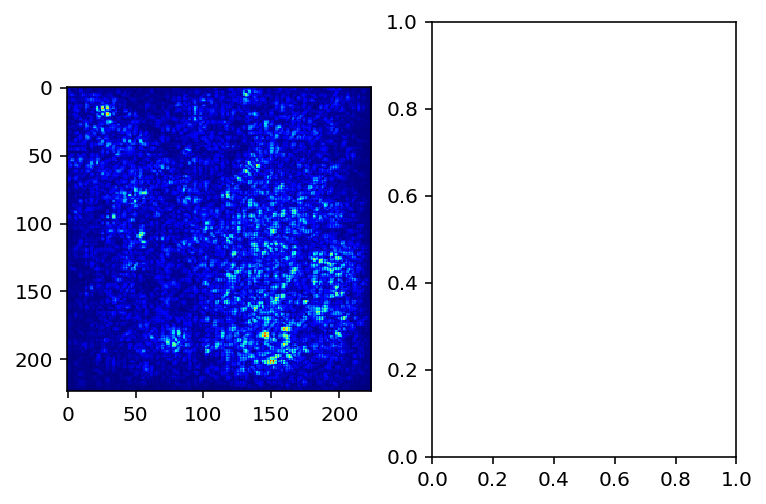

In [79]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

f, ax = plt.subplots(1, 2)
for i, img in enumerate([xmod]):    
    # 20 is the imagenet index corresponding to `ouzel`
    gradsMobileNetTF = visualize_saliency(vbModel_MobileNetTF, vblayer_idxMobileNetTF, 
                                       filter_indices=None, seed_input=img, backprop_modifier=None)
    
    # visualize grads as heatmap
    ax[i].imshow(gradsMobileNetTF, cmap='jet')

Text(0.5,1,'MobileNet Transfer Learning Heatmap')

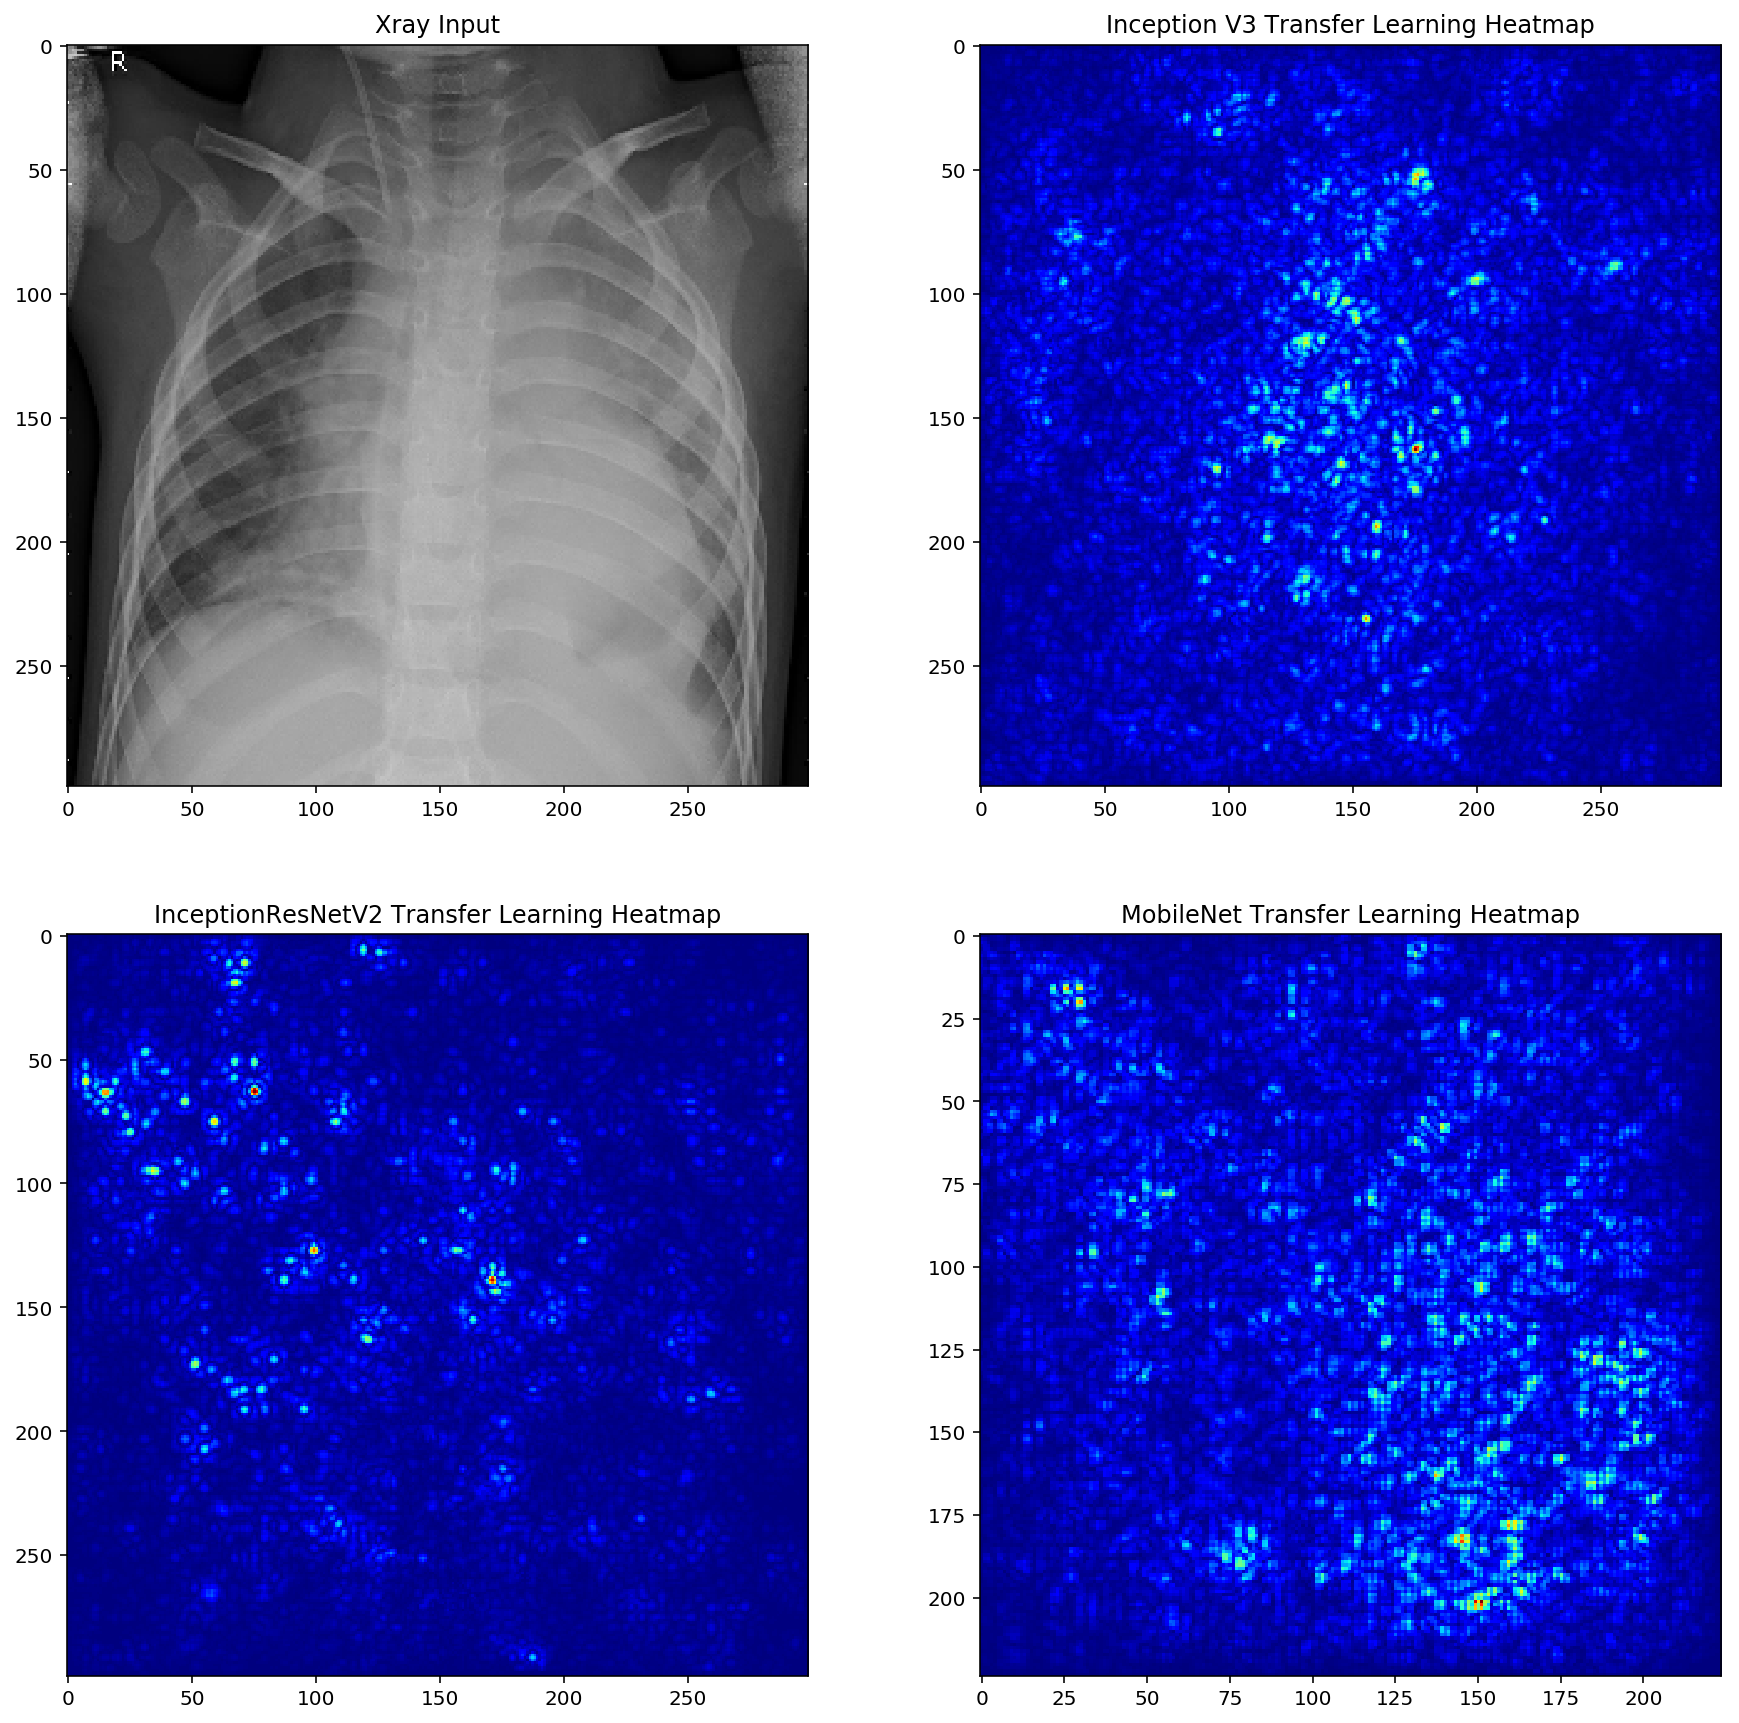

In [80]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(tmp)
ax1.set_title("Xray Input")

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(grads, cmap='jet')
ax2.set_title("Inception V3 Transfer Learning Heatmap")

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(gradsResNetTF, cmap='jet')
ax3.set_title("InceptionResNetV2 Transfer Learning Heatmap")

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(gradsMobileNetTF, cmap='jet')
ax4.set_title("MobileNet Transfer Learning Heatmap")
